# Transfer Learning - Facial Recognition Application

### Creating File Structure

In [1]:
import os, shutil
from tqdm import tqdm
 
original_dataset_dir = '/Users/priyansh/iXDataScience/facial-recognition-transfer-learning/CroppedYale'
 
# create a new directory for the subset of people images
base_dir = '/Users/priyansh/iXDataScience/facial-recognition-transfer-learning/data'
os.mkdir(base_dir)
 
# create base training, validation and test directories
def join_create_dir(base, suffix):
    """
    Join a base directory with a new folder name, creating the new
    directory and returning its path.
   
    :param base: base directory path
    :param suffix: folder to append
    """
    new_dir = os.path.join(base, suffix)
    os.mkdir(new_dir)
    return new_dir

train_dir = join_create_dir(base_dir, 'train')
validation_dir = join_create_dir(base_dir, 'validation')
test_dir = join_create_dir(base_dir, 'test')

def split_people(base):
    """
    Stratifies a base directory into subdirectories for cats and dogs.
   
    :param base: base directory for which to create subdirectories
    """
    for i in range(1, 39):
        person_dir = os.path.join(base, 'person' + str(i))
        os.mkdir(person_dir)
        
    return person_dir

split_people(train_dir)
split_people(test_dir)
split_people(validation_dir)
 
def move_files(person, mini, maxi, datatype):
    """
    Move a subset of images into the relavant subdir for cats or dogs.
    :param animal: cat or dog
    :param min: min image index
    :param max: max immage index
    :param datatype: train, validation or test set
    """
    
    fnames = ['{}-{}.jpg'.format(person, i) for i in range(mini, maxi)]
    pbar = tqdm(range(mini, maxi), desc=f'copying {person}')
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(f'data/{datatype}/{person}/', fname)
        shutil.copyfile(src, dst)
        pbar.update()
    pbar.close()   

for i in range(1, 39):
    move_files('person' + str(i), 1, 31, 'train')
    move_files('person' + str(i), 31, 41, 'validation')
    move_files('person' + str(i), 41, 51, 'test')

copying person38: 100%|██████████| 10/10 [00:00<00:00, 1766.84it/s]


### Importing InceptionV3 Model

In [2]:
from keras.applications import inception_v3

conv_base = inception_v3.InceptionV3(weights='imagenet',
                                     include_top=False,
                                     input_shape=(168, 192, 3));

Using TensorFlow backend.


In [3]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 168, 192, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 83, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 83, 95, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 83, 95, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
conv_base.trainable = False

### Feature Extraction

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook as tqdm

base_dir = '/Users/priyansh/iXDataScience/facial-recognition-transfer-learning/data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 5

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 4, 2048))
    labels = np.zeros(shape=(sample_count, 38))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(168, 192),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    pbar = tqdm(range(sample_count // batch_size - 1))
    for inputs_batch, labels_batch in generator:
        # compute features for input images in batch
        features_batch = conv_base.predict(inputs_batch)
        # store the computed features and labels in larger Numpy arr
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
        pbar.update()
    pbar.close()
    return features, labels

train_features, train_labels = extract_features(train_dir, 1140)
validation_features, validation_labels = extract_features(validation_dir, 380)
test_features, test_labels = extract_features(test_dir, 380)

Found 1140 images belonging to 38 classes.



Found 380 images belonging to 38 classes.



Found 380 images belonging to 38 classes.


In [6]:
train_features = np.reshape(train_features, (1140, 3 * 4 * 2048))
validation_features = np.reshape(validation_features, (380, 3 * 4 * 2048))
test_features = np.reshape(test_features, (380, 3 * 4 * 2048))

### Training Model

In [15]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=3 * 4 * 2048))
model.add(layers.Dense(38, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=5,
                    validation_data=(validation_features, validation_labels))

Train on 1140 samples, validate on 380 samples
Epoch 1/10
1140/1140 [==============================] - 31s 28ms/step - loss: 3.2024 - acc: 0.2202 - val_loss: 2.5014 - val_acc: 0.3579
Epoch 2/10
1140/1140 [==============================] - 30s 26ms/step - loss: 1.4586 - acc: 0.6561 - val_loss: 1.9553 - val_acc: 0.5579
Epoch 3/10
1140/1140 [==============================] - 28s 24ms/step - loss: 0.6631 - acc: 0.8561 - val_loss: 1.5064 - val_acc: 0.6500
Epoch 4/10
1140/1140 [==============================] - 28s 24ms/step - loss: 0.2771 - acc: 0.9614 - val_loss: 1.7008 - val_acc: 0.5684
Epoch 5/10
1140/1140 [==============================] - 29s 26ms/step - loss: 0.1119 - acc: 0.9895 - val_loss: 1.3109 - val_acc: 0.6974
Epoch 6/10
1140/1140 [==============================] - 28s 24ms/step - loss: 0.0518 - acc: 0.9947 - val_loss: 1.3546 - val_acc: 0.7053
Epoch 7/10
1140/1140 [==============================] - 27s 23ms/step - loss: 0.0236 - acc: 0.9965 - val_loss: 1.3613 - val_acc: 0.6947
E

In [16]:
test_loss, test_acc = model.evaluate(test_features, test_labels)

380/380 [==============================] - 0s 660us/step


In [17]:
print('Test accuracy: %s' % test_acc)

Test accuracy: 0.7473684223074663


### Training and Validation Visualizations

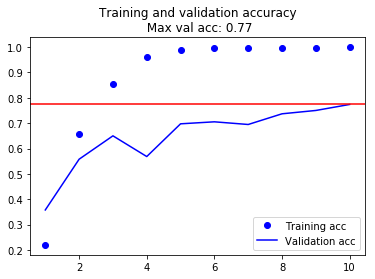

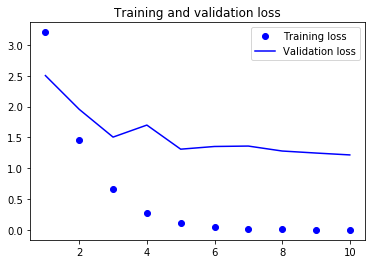

In [18]:
%matplotlib inline
from utils import show_plots
show_plots(history.history['acc'],
           history.history['val_acc'],
           history.history['loss'],
           history.history['val_loss'])

In [24]:
from sklearn.metrics import roc_curve, auc

test_preds = model.predict_proba(test_features)

def getAUC(classNum, nos):
    """
    Calculates the AUC for a multiclass problem by converting it
    to a binary problem, e.g. the test data is either part of the
    specified class or not.
    
    :Inputs:
    * classNum: classification number of person
    * nos: number of samples in test data
    :Outputs:
    * fpr: false positive rate vector
    * tpr: true positive rate vector
    * roc_auc: area under the ROC curve
    """
    tLabels = [test_labels[i,classNum-1] for i in range(nos)]
    tPreds = [test_preds[i,classNum-1] for i in range(nos)]
    fpr, tpr, _ = roc_curve(tLabels, tPreds)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

aucs = np.zeros((38))
for i in range(38):
    _, _, roc_auc = getAUC(i+1, 380)
    aucs[i] = roc_auc
mean_auc = np.mean(aucs)
print('Average AUC: %s' % mean_auc)

Average AUC: 0.9760668563300143


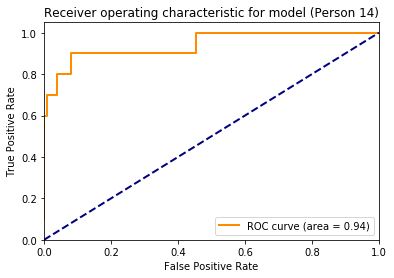

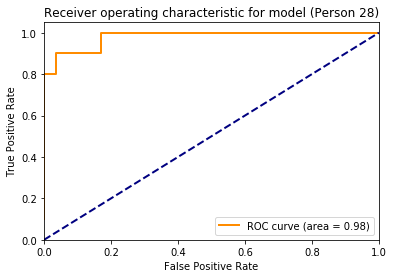

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotROCCurve(classNum):
    """
    Plots the ROC curve for the specified class number.
    Returns nothing.
    
    :Inputs:
    * classNum: classification number of person
    """
    fpr, tpr, roc_auc = getAUC(classNum, 380)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for model (Person %s)' % classNum)
    plt.legend(loc="lower right")
    plt.show()

plotROCCurve(14)
plotROCCurve(28)

### Random Classifier

In [21]:
from random import randint

def pick(num_samples, num_cats):
    correct = 0
    incorrect = 0
    for person in range(num_samples):
        i = randint(0, num_cats-1)
        if test_labels[person,i] == 1:
            correct += 1
        else:
            incorrect += 1
    return correct / (correct + incorrect)

In [28]:
avg = 0
trials = 50
for i in range(trials):
    avg += pick(380,38)
    
print('Average accuracy of random guessing: %s' % (avg/trials))

Average accuracy of random guessing: 0.024105263157894723
